In [1]:
import imutils
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2

# Object detection using ResNet50

#### Data Augmentation

Using imgae pyramid technique as a data augmentation method.

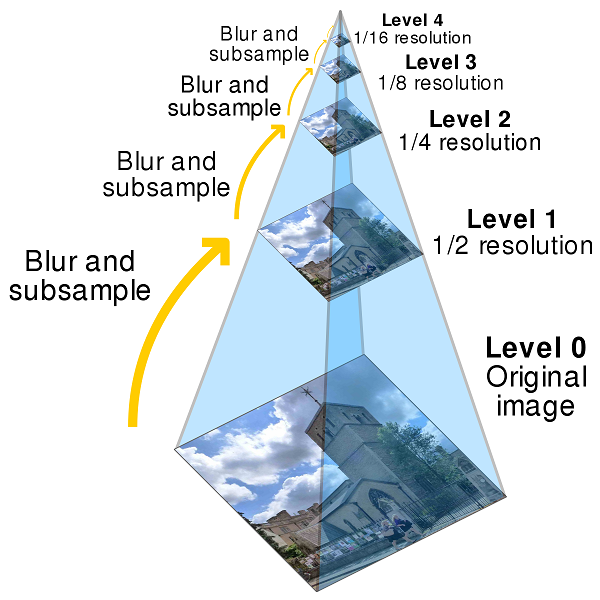

In [2]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    yield image #first image in the pyramid is the input itself.
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

#### Object detection

Object detection method includes:

1. Gathering fixed size ROIs by sliding ltr and utd all other the image (sliding_window(...)).
2. Classifying the ROIs using ResNet50 classifier.
3. The ROIs with more than a specific confidence are selected.
4. Using Non Maxima Suppression method, best ROIs are presented as object detection results

In [3]:
def sliding_window(image, step, ws):
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

Some parameters are initialized in the following box and here are their definitions:

- WIDTH: All images are resized regaring to this value to ensure images will fit on the screen.

- PYR_SCALE: The scale of each layer regarding to the next layer in image pyramid.

- WIN_STEP: The number of pixels to be skipped in both x and y directions, while using the sliding window method.

- ROI_SIZE: The size of the Region of Interest. 

- INPUT_SIZE: The classification CNN dimensions.

In [4]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
INPUT_SIZE = (224, 224)

In [5]:
def detect_with_classifier(image, size, min_conf=0.9, visualize=-1):
    ROI_SIZE = eval(size)
    print("[INFO] loading network...")
    model = ResNet101(weights="imagenet", include_top=True)
    orig = cv2.imread(image)
    orig = imutils.resize(orig, width=WIDTH)
    (H, W) = orig.shape[:2]
    pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
    rois = []
    locs = []
    start = time.time()
    for image in pyramid:
        scale = W / float(image.shape[1])
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = img_to_array(roi)
            roi = preprocess_input(roi)
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
            if visualize > 0:
                clone = orig.copy()
                cv2.rectangle(clone, (x, y), (x + w, y + h),
                    (0, 255, 0), 2)
                cv2.imshow("Visualization", clone)
                cv2.imshow("ROI", roiOrig)
                cv2.waitKey(0)
                
    end = time.time()
    print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
        end - start))
    rois = np.array(rois, dtype="float32")
    print("[INFO] classifying ROIs...")
    start = time.time()
    preds = model.predict(rois)
    end = time.time()
    print("[INFO] classifying ROIs took {:.5f} seconds".format(
        end - start))
    preds = imagenet_utils.decode_predictions(preds, top=1)
    labels = {}
    for (i, p) in enumerate(preds):
        (imagenetID, label, prob) = p[0]
        if prob >= min_conf:
            box = locs[i]
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L
    print(labels.keys())
    for label in labels.keys():
        print("[INFO] showing results for '{}'".format(label))
        clone = orig.copy()
        for (box, prob) in labels[label]:
            (startX, startY, endX, endY) = box
            cv2.rectangle(clone, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
        cv2.imshow("Before", clone)
        clone = orig.copy()
        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba)
        for (startX, startY, endX, endY) in boxes:
            cv2.rectangle(clone, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        cv2.imshow("After", clone)
        cv2.waitKey(0)

In [28]:
detect_with_classifier(image="./Images/9.jpg",
                    size="(400,400)",
                    min_conf=0.90,
                    visualize=-1)

[INFO] loading network...
[INFO] looping over pyramid/windows took 0.17634 seconds
[INFO] classifying ROIs...
11/11 [==============================] - 8s 700ms/step
[INFO] classifying ROIs took 8.95666 seconds
dict_keys(['Egyptian_cat', 'Samoyed'])
[INFO] showing results for 'Egyptian_cat'
[INFO] showing results for 'Samoyed'
